# Notebook 8: Spatial-Temporal Patterns

## Purpose
Visualize geographic and temporal patterns in the PathWild elk data.

## Key Questions
- Is spatial coverage uniform or clustered?
- Do elk show seasonal migration patterns?
- Are there spatial hotspots for elk presence?
- Do features show expected seasonal cycles?

## Key Observations to Look For
- **Spatial Clustering**: Elk observations should cluster in known habitat areas
- **Seasonal Migration**: Elevation changes in winter (lower) vs summer (higher)
- **NDVI Patterns**: Should correlate with vegetation zones
- **Temporal Autocorrelation**: Could affect train/test splitting

In [12]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Determine project root and output directories
possible_roots = [
    Path('.'),  # If running from project root
    Path('..'),  # If running from notebooks directory
    Path('../..'),  # If running from subdirectory
]

data_root = None
for root in possible_roots:
    if (root / 'data' / 'features').exists():
        data_root = root / 'data'
        break

if data_root is None:
    data_root = Path('../data')

# Create output directories relative to project root
figures_dir = data_root / 'figures'
reports_dir = data_root / 'reports'
figures_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

print(f'✓ Setup complete')
print(f'  Output directory: {data_root.absolute()}')

✓ Setup complete
  Output directory: /Users/jongalentine/Projects/pathwild/notebooks/../data


## 1. Load Data and Detect Columns

This section loads the dataset and identifies geographic (lat/lon), temporal (timestamp), and key feature columns for spatial-temporal analysis.

### What to Look For
- Confirm latitude and longitude columns are detected
- Verify timestamp/date column presence for temporal analysis
- Note NDVI and elevation columns for migration analysis

In [13]:
# Load data
from pathlib import Path

# Try multiple possible paths
possible_paths = [
    Path('data/features/complete_context.csv'),  # From project root
    Path('../data/features/complete_context.csv'),  # From notebooks directory
    Path('../../data/features/complete_context.csv'),  # From subdirectory
]

data_path = None
for path in possible_paths:
    if path.exists():
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError(f'Data file not found. Tried: {[str(p) for p in possible_paths]}')

print(f'Loading data from: {data_path}')
df = pd.read_csv(data_path)

# Detect key columns
lat_col = None
lon_col = None
presence_col = None
ndvi_col = None
elevation_col = None

for col in df.columns:
    if 'lat' in col.lower() and 'lon' not in col.lower():
        lat_col = col
    if 'lon' in col.lower() and 'lat' not in col.lower():
        lon_col = col
    if col.lower() in ['presence', 'target', 'label', 'is_presence', 'elk_present']:
        presence_col = col
    # Prefer exact match 'ndvi' over other NDVI-related columns
    if col.lower() == 'ndvi':
        ndvi_col = col
    elif 'ndvi' in col.lower() and 'age' not in col.lower() and 'summer' not in col.lower() and ndvi_col is None:
        ndvi_col = col
    if 'elev' in col.lower() or 'altitude' in col.lower():
        elevation_col = col

# Detect temporal columns (year, month - no timestamp in this dataset)
year_col = 'year' if 'year' in df.columns else None
month_col = 'month' if 'month' in df.columns else None
has_day_of_year = 'day_of_year_cos' in df.columns and 'day_of_year_sin' in df.columns

print(f'Dataset shape: {df.shape}')
print(f'Year column: {year_col}')
print(f'Month column: {month_col}')
print(f'Day of year encoding: {has_day_of_year}')
print(f'Latitude: {lat_col}')
print(f'Longitude: {lon_col}')
print(f'Presence: {presence_col}')
print(f'NDVI: {ndvi_col}')
print(f'Elevation: {elevation_col}')

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

Loading data from: ../data/features/complete_context.csv
Dataset shape: (431862, 32)
Year column: year
Month column: month
Day of year encoding: True
Latitude: latitude
Longitude: longitude
Presence: elk_present
NDVI: ndvi
Elevation: moon_altitude_midnight


## 2. Static Spatial Visualization

This section creates a map showing the geographic distribution of all observations, colored by presence/absence status. Understanding spatial coverage is fundamental to interpreting model predictions.

### What This Code Does
- Creates a scatter plot of all GPS locations
- Colors points by presence (blue) vs absence (red)
- Samples down to 20,000 points if dataset is larger (for visualization performance)

### Interpreting the Spatial Map

**Cluster Patterns:**
- **Distinct clusters**: Expected - should see separation between study areas
- **Overlapping presence/absence**: Good - model learns habitat, not location
- **Spatially separated classes**: Concerning - model may learn geography instead of ecology

**Study Area Identification:**
Look for clusters corresponding to:
- Northern Bighorn Mountains (NE Wyoming)
- Southern Bighorn Mountains (central-east Wyoming)
- National Elk Refuge (NW Wyoming, near Jackson)
- Southern Greater Yellowstone Ecosystem (NW Wyoming)

### What to Look For
- **Coverage gaps**: Areas without observations cannot be reliably predicted
- **Edge effects**: Sparse data at cluster boundaries may have uncertain predictions
- **Presence/absence mixing**: Good sign - indicates habitat-based sampling
- **Study area sizes**: Larger areas provide more training data

### Elk Ecology Context
The spatial distribution reflects both elk biology and data collection methods:
- Presence points come from GPS collars on individual elk
- Absence points are generated (pseudo-absences) within similar geographic ranges
- True absence data is rare in wildlife studies - we infer from lack of observations

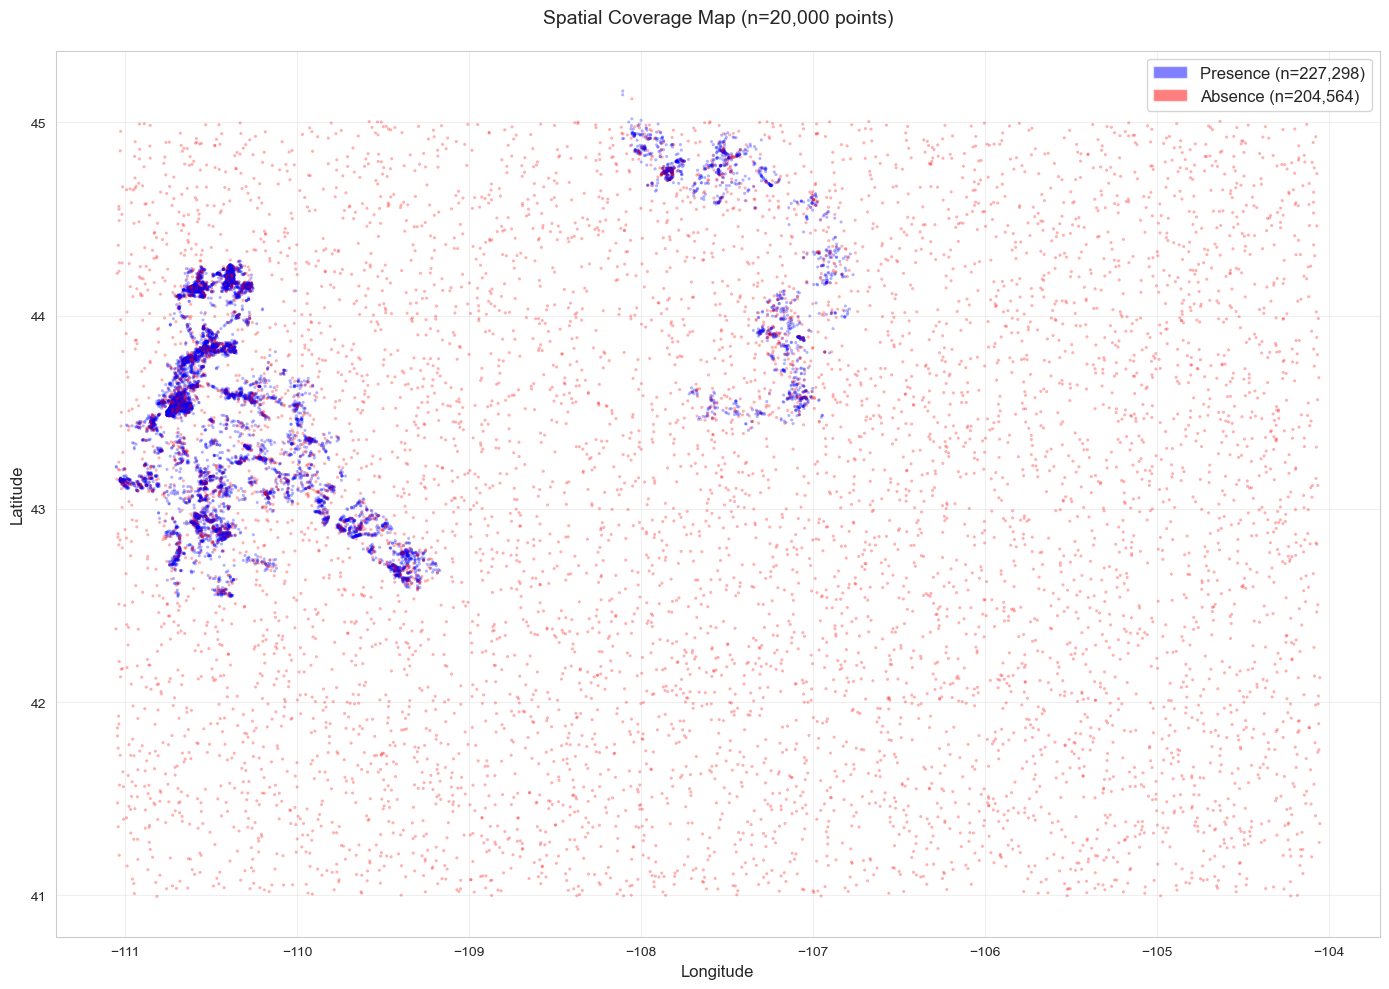

✓ Saved spatial coverage map


In [14]:
# Create scatter plot of GPS points
if lat_col and lon_col:
    plt.figure(figsize=(14, 10))
    
    # Sample if too many points
    sample_size = min(20000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42)
    
    # Color by presence if available
    if presence_col:
        colors = df_sample[presence_col].map({1: 'blue', 0: 'red', True: 'blue', False: 'red'})
        plt.scatter(
            df_sample[lon_col],
            df_sample[lat_col],
            c=colors,
            alpha=0.3,
            s=5,
            edgecolors='none'
        )
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', alpha=0.5, label=f'Presence (n={(df[presence_col]==1).sum():,})'),
            Patch(facecolor='red', alpha=0.5, label=f'Absence (n={(df[presence_col]==0).sum():,})')
        ]
        plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    else:
        plt.scatter(
            df_sample[lon_col],
            df_sample[lat_col],
            alpha=0.3,
            s=5,
            color='blue',
            edgecolors='none'
        )
    
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title(f'Spatial Coverage Map (n={sample_size:,} points)', fontsize=14, pad=20)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'spatial_coverage.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved spatial coverage map')
else:
    print('⚠ Cannot create spatial map without lat/lon columns')

## 3. NDVI Spatial Heatmap

NDVI (vegetation greenness) varies spatially based on elevation, aspect, precipitation, and land cover. This heatmap reveals vegetation productivity patterns across the study area.

### What This Code Does
- Creates a hexbin plot where each hexagon represents a geographic area
- Colors hexagons by mean NDVI value within that area
- Uses a red-yellow-green color scale (red=low NDVI, green=high NDVI)

### Interpreting the NDVI Heatmap

**Color Scale:**
- **Red/Orange (NDVI 0.0-0.3)**: Sparse vegetation - barren, rock, snow, or very dry areas
- **Yellow (NDVI 0.3-0.5)**: Moderate vegetation - grasslands, shrublands
- **Green (NDVI 0.5-0.8)**: Dense vegetation - forests, lush meadows, riparian areas

**Expected Spatial Patterns:**
- **Elevation gradient**: Higher elevations often have lower NDVI (shorter growing season)
- **Aspect effects**: South-facing slopes may be greener (more sun) or drier (more evaporation)
- **Riparian corridors**: River valleys should show higher NDVI (water availability)
- **Forest patches**: Dark green areas indicate dense forest cover

### What to Look For
- **Consistent NDVI patterns**: Validates that satellite data is being retrieved correctly
- **Unexpected uniformity**: If all areas have same NDVI, data may be placeholder values
- **High NDVI at high elevation**: May indicate mislabeled coordinates or data errors
- **Sharp boundaries**: May indicate land use boundaries or data collection artifacts

### Elk Ecology Context
Elk select habitat based on NDVI for two main reasons:
1. **Forage quality**: Higher NDVI = more digestible, protein-rich vegetation
2. **Cover**: Forested areas (high NDVI) provide security from predators

The "green wave hypothesis" suggests elk track the leading edge of spring green-up during migration, following optimal forage conditions up in elevation as summer progresses.

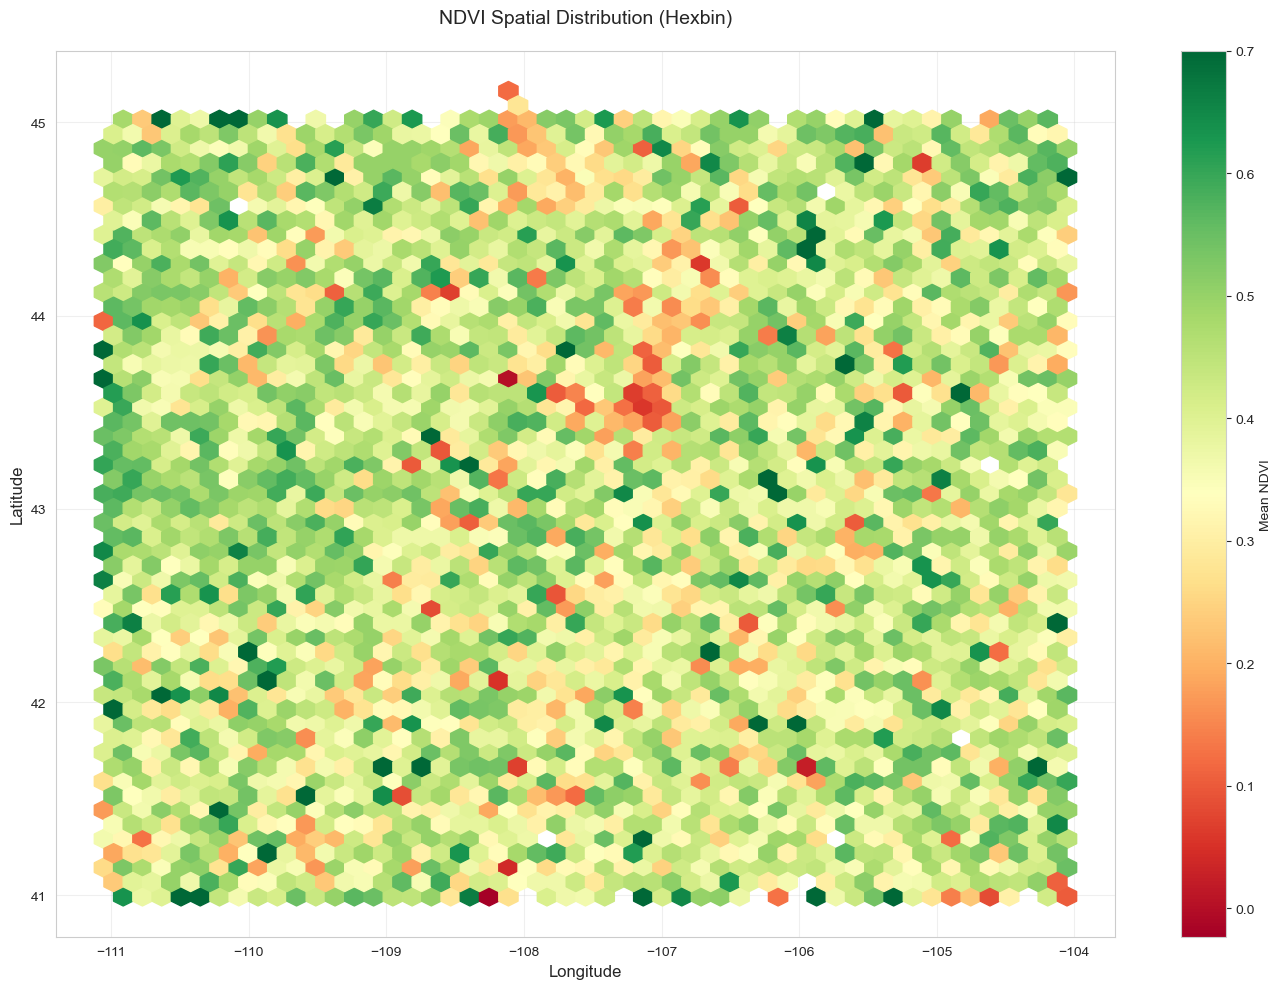

✓ Saved NDVI spatial heatmap

NDVI statistics by region:
  Overall mean: 0.414
  Overall std: 0.221


In [15]:
# Create NDVI spatial heatmap
if ndvi_col and lat_col and lon_col:
    plt.figure(figsize=(14, 10))
    
    # Filter to valid NDVI values
    df_ndvi = df[[lon_col, lat_col, ndvi_col]].dropna()
    
    # Sample if too large
    if len(df_ndvi) > 50000:
        df_ndvi = df_ndvi.sample(n=50000, random_state=42)
    
    # Create hexbin plot
    hexbin = plt.hexbin(
        df_ndvi[lon_col],
        df_ndvi[lat_col],
        C=df_ndvi[ndvi_col],
        gridsize=50,
        cmap='RdYlGn',
        reduce_C_function=np.mean,
        mincnt=1
    )
    
    plt.colorbar(hexbin, label='Mean NDVI')
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('NDVI Spatial Distribution (Hexbin)', fontsize=14, pad=20)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'ndvi_spatial_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved NDVI spatial heatmap')
    
    # Statistics by region
    print('\nNDVI statistics by region:')
    print(f'  Overall mean: {df_ndvi[ndvi_col].mean():.3f}')
    print(f'  Overall std: {df_ndvi[ndvi_col].std():.3f}')
else:
    print('⚠ Cannot create NDVI heatmap without NDVI and lat/lon columns')

## 4. Temporal Line Plots

Time series analysis reveals how features change over time, including seasonal cycles, trends, and anomalies. This section visualizes daily averages with smoothing to reveal patterns.

### What This Code Does
- Groups observations by date and calculates daily mean for each feature
- Plots raw daily values (gray) with 7-day rolling average (blue)
- Creates subplots for multiple features simultaneously

### Interpreting Time Series Plots

**Pattern Types:**
- **Annual cycle**: Clear seasonal repetition (NDVI, temperature, snow)
- **Trend**: Long-term increase or decrease over years
- **Noise**: High variability around trend/cycle (weather-dependent features)
- **Gaps**: Missing data periods (may indicate data collection issues)

**Rolling Average (Blue Line):**
- Smooths out daily noise to reveal underlying patterns
- 7-day window captures weekly cycles while preserving seasonal signals
- Flat sections indicate stable periods; steep slopes indicate rapid change

### What to Look For
- **NDVI annual cycle**: Should peak in summer, trough in winter
- **Temperature cycle**: Clear summer peak, winter trough
- **Snow depth cycle**: Peak in late winter/early spring, zero in summer
- **Anomalous years**: Drought years may show lower NDVI peaks
- **Data gaps**: Extended flat lines or missing periods indicate data issues

### Elk Ecology Context
Temporal patterns directly affect elk behavior:
- **Spring green-up** (rapidly rising NDVI): Triggers migration to summer range
- **Summer peak** (high NDVI): Elk disperse to alpine meadows
- **Fall senescence** (declining NDVI): Return to lower elevations begins
- **Winter** (low NDVI, high snow): Concentration on winter range

The model should learn that elk presence probability varies with these temporal environmental conditions.

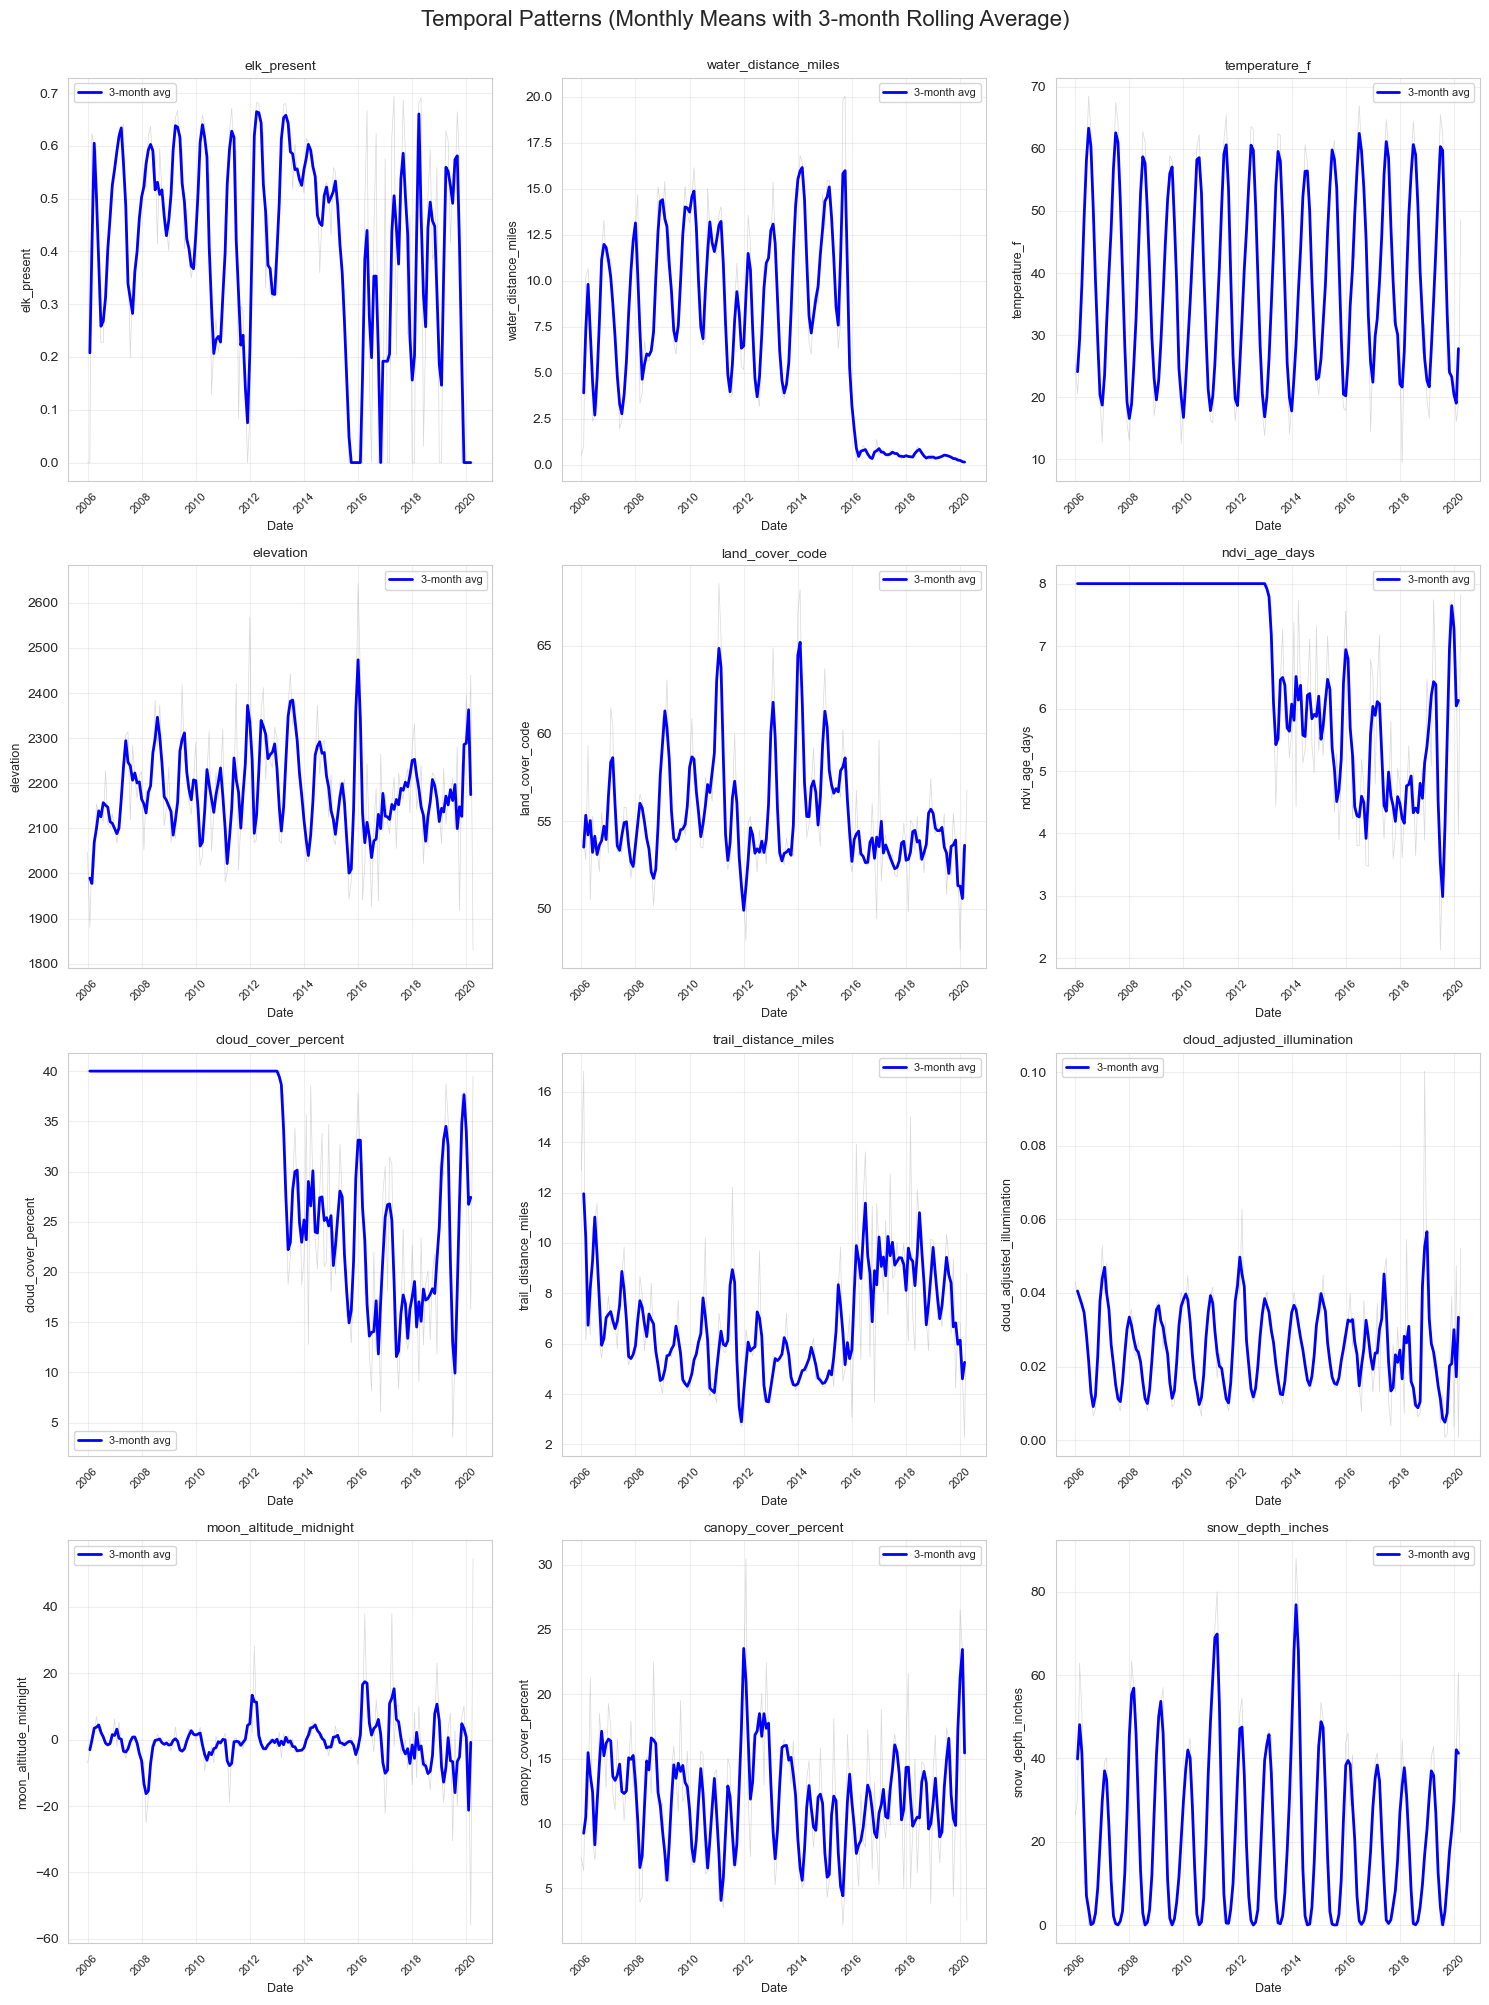

✓ Saved temporal timeseries


In [16]:
# Plot temporal patterns for all numeric features using year and month
if year_col and month_col:
    # Select features for temporal analysis (exclude temporal and coordinate columns)
    temporal_features = [col for col in numeric_cols 
                        if col not in ['month', 'year', 'day_of_year_cos', 'day_of_year_sin', 
                                       lat_col, lon_col]][:12]
    
    # Create a year-month index for grouping
    # Convert float year/month to int first to avoid ".0" in string format
    df['year_month'] = df[year_col].astype(int).astype(str) + '-' + df[month_col].astype(int).astype(str).str.zfill(2)
    df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
    
    n_cols = 3
    n_rows = (len(temporal_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(temporal_features):
        ax = axes[idx]
        
        # Group by year-month and calculate mean
        monthly_mean = df.groupby('year_month')[col].mean().sort_index()
        
        # Plot with rolling average
        ax.plot(monthly_mean.index, monthly_mean.values, alpha=0.3, color='gray', linewidth=0.5)
        
        # 3-month rolling average (since data is monthly)
        rolling = monthly_mean.rolling(window=3, center=True).mean()
        ax.plot(rolling.index, rolling.values, color='blue', linewidth=2, label='3-month avg')
        
        ax.set_xlabel('Date', fontsize=9)
        ax.set_ylabel(col, fontsize=9)
        ax.set_title(col, fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
    
    # Hide extra subplots
    for idx in range(len(temporal_features), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Temporal Patterns (Monthly Means with 3-month Rolling Average)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'temporal_timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved temporal timeseries')
elif month_col:
    print('⚠ Only month column available - showing seasonal patterns instead of time series')
    # Fall back to just monthly patterns
    temporal_features = [col for col in numeric_cols 
                        if col not in ['month', 'year', lat_col, lon_col]][:12]
    
    n_cols = 3
    n_rows = (len(temporal_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(temporal_features):
        ax = axes[idx]
        monthly_mean = df.groupby(month_col)[col].mean()
        ax.plot(monthly_mean.index, monthly_mean.values, marker='o', linewidth=2, markersize=8)
        ax.set_xlabel('Month', fontsize=10)
        ax.set_ylabel(f'Mean {col}', fontsize=10)
        ax.set_title(col, fontsize=11)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        ax.grid(alpha=0.3)
    
    for idx in range(len(temporal_features), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Seasonal Patterns (Monthly Means)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'temporal_timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved seasonal patterns')
else:
    print('⚠ Cannot create temporal plots without year/month columns')

## 5. Month vs Feature Heatmap

A heatmap showing normalized feature values by month provides a compact view of seasonal patterns across all features simultaneously. This helps identify which features have strong vs weak seasonal signals.

### What This Code Does
- Calculates monthly mean for each feature
- Normalizes each feature to 0-1 scale (for comparability)
- Creates a heatmap with months as columns and features as rows

### Interpreting the Seasonal Heatmap

**Color Scale (Normalized 0-1):**
- **Dark red/green**: Minimum/maximum values for that feature
- **Yellow/intermediate**: Mid-range values
- Each row is independently normalized - colors are relative within each feature

**Pattern Recognition:**
- **Horizontal bands (same color across months)**: No seasonal signal - suspicious for weather/vegetation features
- **Vertical patterns (columns similar)**: Features correlated with each other
- **Diagonal patterns**: Lagged relationships between features
- **Single month spike**: May indicate data collection artifact

### What to Look For
- **NDVI row**: Should be green in summer (Jun-Aug), red in winter (Dec-Feb)
- **Temperature row**: Should match NDVI pattern
- **Snow row**: Should be inverted - green in winter, red in summer
- **Flat rows**: Features with no seasonal variation may be placeholder values

### Expected Seasonal Heatmap Structure
```
         Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
NDVI      R    R    O    Y    G    G    G    G    Y    O    R    R
Temp      R    R    O    Y    G    G    G    G    Y    O    R    R
Snow      G    G    G    Y    O    R    R    R    R    O    Y    G
Elevation Y    Y    Y    O    G    G    G    G    G    O    Y    Y
```
(R=Red/Low, Y=Yellow/Mid, G=Green/High, O=Orange)

### Elk Ecology Context
The heatmap should reveal the environmental template that drives elk seasonal behavior:
- Summer: High NDVI + high elevation + low snow = summer range conditions
- Winter: Low NDVI + low elevation + high snow = winter range conditions
- Spring/Fall: Transitional values = migration periods

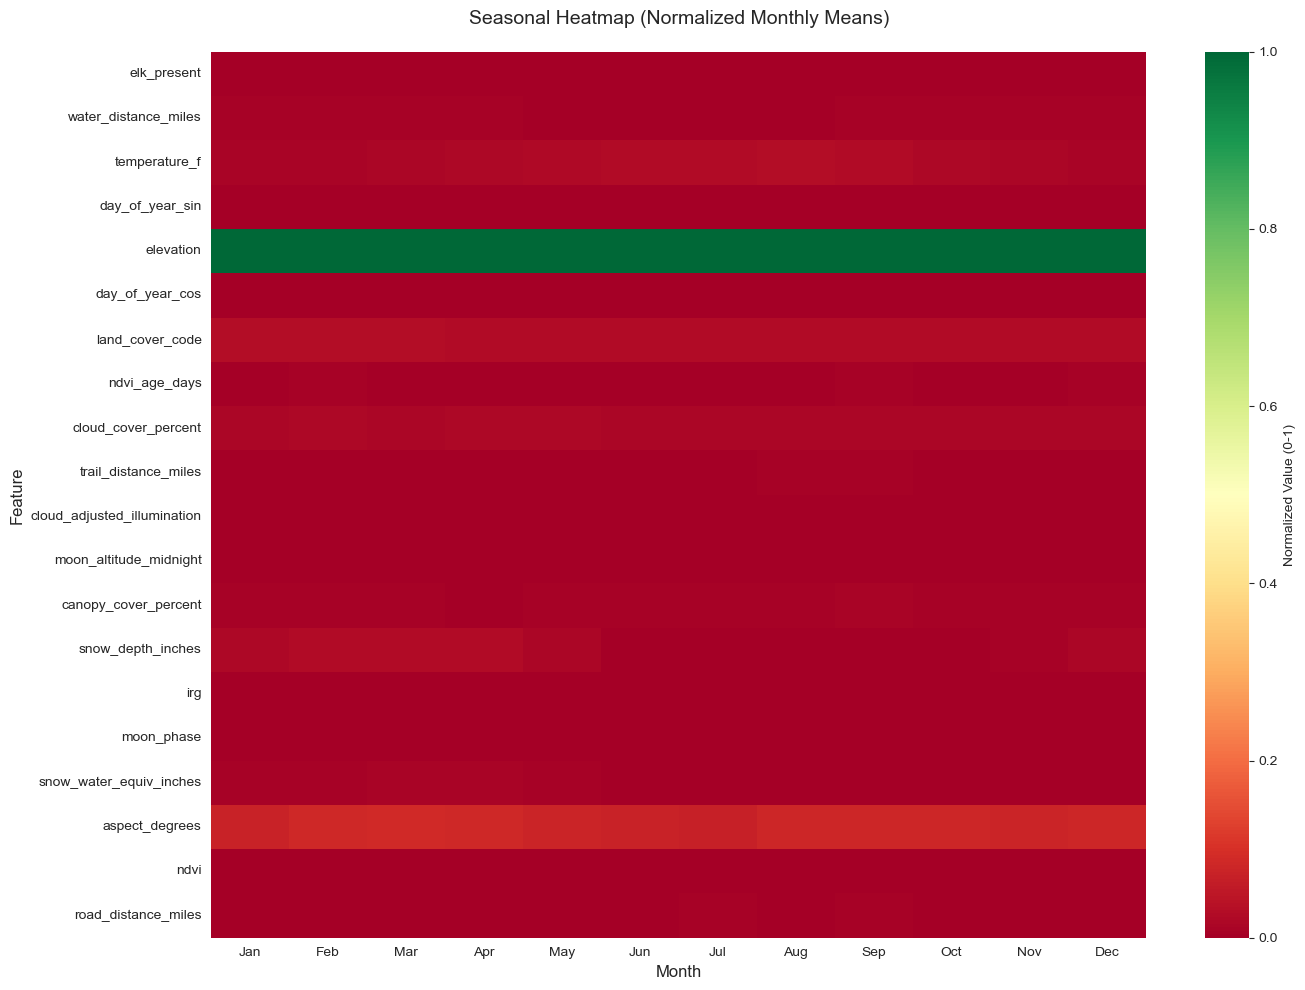

✓ Saved seasonal heatmap


In [17]:
# Create heatmap showing seasonal patterns
if month_col and 'month' in df.columns:
    # Select features for heatmap
    heatmap_features = [col for col in numeric_cols 
                       if col not in ['month', 'year', lat_col, lon_col]][:20]
    
    # Calculate monthly means
    monthly_data = df.groupby('month')[heatmap_features].mean()
    
    # Normalize each feature (0-1 scale) for better visualization
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    monthly_normalized = pd.DataFrame(
        scaler.fit_transform(monthly_data.T).T,
        index=monthly_data.index,
        columns=monthly_data.columns
    )
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        monthly_normalized.T,
        cmap='RdYlGn',
        cbar_kws={'label': 'Normalized Value (0-1)'},
        xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        yticklabels=monthly_normalized.columns
    )
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Seasonal Heatmap (Normalized Monthly Means)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(figures_dir / 'seasonal_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved seasonal heatmap')
else:
    print('⚠ Cannot create seasonal heatmap without timestamp column')

## 6. Spatial Clustering Analysis

Comparing spatial density of presence vs absence observations reveals whether the pseudo-absence generation strategy created appropriate spatial contrast. This section uses hexbin density plots to visualize observation clustering.

### What This Code Does
- Creates separate density heatmaps for presence and absence observations
- Uses hexagonal binning to aggregate nearby points
- Colors by observation count within each hexagon

### Interpreting Density Plots

**Side-by-Side Comparison:**
- **Similar patterns**: Presences and absences sample the same geographic areas
- **Different patterns**: Concerning - model may learn location instead of habitat
- **Complementary patterns**: Ideal - absence fills gaps where presence is sparse

**Density Hotspots:**
- **Presence hotspots**: Areas of high elk activity (likely core habitat)
- **Absence hotspots**: Areas where pseudo-absences were concentrated
- **Matching hotspots**: Good - both classes sample same areas

### What to Look For
- **Geographic overlap**: Presence and absence should overlap spatially
- **Absence coverage**: Absences should extend slightly beyond presence range
- **Isolated clusters**: Small isolated clusters may cause model overfitting
- **Edge density**: Higher density at edges may indicate boundary artifacts

### Pseudo-Absence Quality Check
The pseudo-absence generation is validated if:
1. **Same study areas**: Absences are within same geographic bounds as presences
2. **Temporal matching**: Absences generated for same months as presences
3. **Feature contrast**: Absence locations have different (worse) habitat features
4. **No obvious spatial separation**: Not simply "north = presence, south = absence"

### Implications for Modeling
- **High spatial overlap**: Model learns habitat features, not location
- **Low spatial overlap**: Consider spatial cross-validation (leave-one-area-out)
- **Clustered presences**: May need to account for spatial autocorrelation

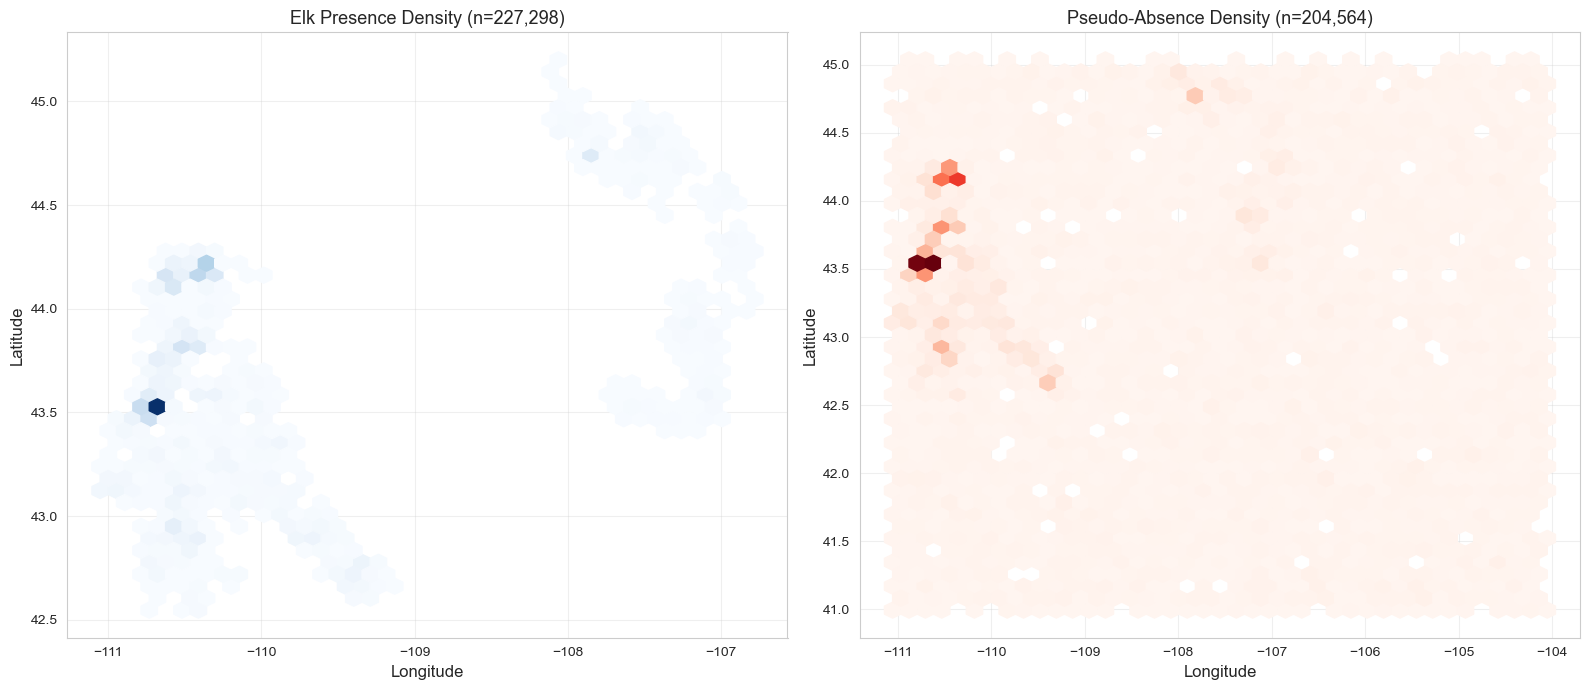

✓ Saved density contours


In [18]:
# Calculate kernel density estimate of elk observations
if lat_col and lon_col and presence_col:
    # Filter to presence observations
    presence_df = df[df[presence_col] == 1][[lat_col, lon_col]].dropna()
    absence_df = df[df[presence_col] == 0][[lat_col, lon_col]].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Presence density
    if len(presence_df) > 0:
        sample_size = min(10000, len(presence_df))
        presence_sample = presence_df.sample(n=sample_size, random_state=42)
        
        axes[0].hexbin(
            presence_sample[lon_col],
            presence_sample[lat_col],
            gridsize=40,
            cmap='Blues',
            mincnt=1
        )
        axes[0].set_xlabel('Longitude', fontsize=12)
        axes[0].set_ylabel('Latitude', fontsize=12)
        axes[0].set_title(f'Elk Presence Density (n={len(presence_df):,})', fontsize=13)
        axes[0].grid(alpha=0.3)
    
    # Absence density
    if len(absence_df) > 0:
        sample_size = min(10000, len(absence_df))
        absence_sample = absence_df.sample(n=sample_size, random_state=42)
        
        axes[1].hexbin(
            absence_sample[lon_col],
            absence_sample[lat_col],
            gridsize=40,
            cmap='Reds',
            mincnt=1
        )
        axes[1].set_xlabel('Longitude', fontsize=12)
        axes[1].set_ylabel('Latitude', fontsize=12)
        axes[1].set_title(f'Pseudo-Absence Density (n={len(absence_df):,})', fontsize=13)
        axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'elk_density_contours.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved density contours')
else:
    print('⚠ Cannot create density plots without lat/lon and presence columns')

## 7. Elevation vs Time (Migration Pattern)

Elk are altitudinal migrants: they move to higher elevations in summer and descend to lower elevations in winter. This section tests whether the data captures this fundamental elk behavior pattern.

### What This Code Does
- Creates a scatter plot of elevation vs date
- Colors points by presence/absence
- Overlays monthly mean elevation trend line
- Calculates seasonal elevation statistics

### Interpreting the Migration Plot

**Expected Pattern:**
- **Winter (Dec-Feb)**: Lowest elevations (winter range, often below 7,000 ft)
- **Spring (Mar-May)**: Rising elevations (following green-up)
- **Summer (Jun-Aug)**: Highest elevations (alpine/subalpine, 8,000-10,000+ ft)
- **Fall (Sep-Nov)**: Declining elevations (return to winter range)

**Seasonal Elevation Difference:**
- **>500 ft difference**: Clear evidence of altitudinal migration
- **200-500 ft difference**: Moderate migration signal
- **<200 ft difference**: Weak or absent migration pattern

### What to Look For
- **Clear seasonal cycle**: Validates that data captures real elk movement
- **Presence vs absence differences**: Should elk observations be at different elevations than absences?
- **Interannual variation**: Some years may show stronger/weaker migration
- **Study area differences**: Different herds may have different migration amplitudes

### Elk Ecology Context
Altitudinal migration is driven by:
1. **Forage tracking**: Following the "green wave" of spring growth
2. **Snow avoidance**: Deep snow limits winter foraging
3. **Thermal regulation**: Seeking cooler temperatures in summer
4. **Predator avoidance**: Alpine areas may have fewer predators
5. **Calving habitat**: Cows seek specific areas for calving (late May-June)

The migration pattern is one of the strongest signals in elk ecology and should be clearly visible in multi-year GPS collar data.

In [19]:
# Analyze elevation changes over time
if elevation_col and month_col and year_col:
    # Sample for visualization
    sample_size = min(50000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42)
    
    plt.figure(figsize=(14, 8))
    
    # Color by presence if available
    if presence_col:
        colors = df_sample[presence_col].map({1: 'blue', 0: 'red', True: 'blue', False: 'red'})
        plt.scatter(
            df_sample[month_col],
            df_sample[elevation_col],
            c=colors,
            alpha=0.2,
            s=10,
            edgecolors='none'
        )
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', alpha=0.5, label='Presence'),
            Patch(facecolor='red', alpha=0.5, label='Absence')
        ]
        plt.legend(handles=legend_elements, loc='upper right')
    else:
        plt.scatter(
            df_sample[month_col],
            df_sample[elevation_col],
            alpha=0.2,
            s=10,
            color='blue',
            edgecolors='none'
        )
    
    # Add monthly trend lines
    if 'month' in df.columns:
        monthly_elev = df.groupby('month')[elevation_col].mean()
        # Create date proxies for plotting
        # Create month indices for plotting
        month_indices = range(1, 13)
        plt.plot(month_indices[:len(monthly_elev)], monthly_elev.values, 
                color='black', linewidth=3, label='Monthly Mean', alpha=0.7)
    
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Elevation (ft)', fontsize=12)
    plt.title('Elevation vs Time (Potential Migration Pattern)', fontsize=14, pad=20)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'elevation_vs_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved elevation vs time plot')
    
    # Analyze seasonal elevation patterns
    if 'month' in df.columns:
        print('\nSeasonal elevation statistics:')
        seasonal_elev = df.groupby('month')[elevation_col].agg(['mean', 'std', 'count'])
        print(seasonal_elev)
        
        winter_elev = df[df['month'].isin([12, 1, 2])][elevation_col].mean()
        summer_elev = df[df['month'].isin([6, 7, 8])][elevation_col].mean()
        elev_diff = summer_elev - winter_elev
        
        print(f'\nWinter (Dec-Feb) mean elevation: {winter_elev:.1f} ft')
        print(f'Summer (Jun-Aug) mean elevation: {summer_elev:.1f} ft')
        print(f'Seasonal difference: {elev_diff:.1f} ft')
        
        if elev_diff > 500:
            print('✓ Evidence of seasonal migration (elk move to higher elevations in summer)')
        else:
            print('⚠ Limited evidence of seasonal migration')
else:
    print('⚠ Cannot analyze elevation patterns without elevation and timestamp columns')

TypeError: scatter() missing 1 required positional argument: 'y'

<Figure size 1400x800 with 0 Axes>

## 8. Temporal Autocorrelation

Autocorrelation measures how correlated observations are with their own past values. High autocorrelation in environmental features or elk behavior has important implications for model training and validation.

### What This Code Does
- Calculates autocorrelation function (ACF) showing correlation at different time lags
- Calculates partial autocorrelation function (PACF) showing direct correlations
- Identifies significant lags that indicate temporal dependencies

### Interpreting ACF/PACF Plots

**ACF (Left Plots):**
- Shows correlation between observation and observations at lag k
- Decaying pattern: Past values gradually lose influence
- Seasonal spikes: Correlation at 12, 24, 36 month lags indicates annual cycles
- Blue bands: Confidence interval - points outside are significant

**PACF (Right Plots):**
- Shows direct correlation after removing intermediate lag effects
- Sharp cutoff: Indicates AR(p) process where p = last significant lag
- Useful for understanding direct temporal dependencies

### What to Look For
- **Slowly decaying ACF**: Strong temporal dependence - random train/test split inappropriate
- **Seasonal spikes at lag 12**: Annual cycle (expected for NDVI, temperature)
- **Short-term spikes (lag 1-7)**: Weather persistence effects
- **No significant lags**: Feature is temporally independent (random split OK)

### Implications for Model Validation

**High Autocorrelation Issues:**
- Random train/test split may have data leakage (nearby times in both sets)
- Model may appear better than it actually is
- Need temporal split (train on past, test on future)

**Recommended Validation Strategies:**
1. **Block temporal split**: Train on years 2006-2020, test on 2021-2024
2. **Time-series CV**: Rolling window validation
3. **Stratified temporal**: Ensure all seasons in both train and test
4. **Spatial-temporal blocks**: Account for both dimensions

### Elk Ecology Context
Temporal autocorrelation reflects:
- **Environmental persistence**: Weather doesn't change randomly day-to-day
- **Behavioral persistence**: Elk stay in areas for extended periods
- **Seasonal cycles**: Annual migration creates 12-month autocorrelation
- **Study design**: GPS fix intervals create regular sampling patterns

In [ ]:
# Analyze temporal autocorrelation
if month_col and year_col:
    # Select a few key features for autocorrelation analysis
    acf_features = [col for col in [ndvi_col, elevation_col, 'temperature', 'precipitation']
                   if col in df.columns][:4]
    
    if len(acf_features) > 0:
        try:
            from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
            
            fig, axes = plt.subplots(len(acf_features), 2, figsize=(14, 4*len(acf_features)))
            if len(acf_features) == 1:
                axes = axes.reshape(1, -1)
            
            for idx, col in enumerate(acf_features):
                # Get time series data
                # Note: Temporal autocorrelation requires time series data
                # Using year-month grouping instead
                ts_data = df.groupby([year_col, month_col])[col].mean().values
                
                # Limit to reasonable size for ACF
                if len(ts_data) > 10000:
                    ts_data = ts_data[:10000]
                
                # ACF plot
                plot_acf(ts_data, lags=40, ax=axes[idx, 0], alpha=0.05)
                axes[idx, 0].set_title(f'{col} - Autocorrelation', fontsize=11)
                axes[idx, 0].grid(alpha=0.3)
                
                # PACF plot
                plot_pacf(ts_data, lags=40, ax=axes[idx, 1], alpha=0.05)
                axes[idx, 1].set_title(f'{col} - Partial Autocorrelation', fontsize=11)
                axes[idx, 1].grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(figures_dir / 'temporal_autocorrelation.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print('✓ Saved temporal autocorrelation plots')
            print('\nInterpretation:')
            print('- Significant lags indicate temporal dependence')
            print('- May need to account for this in train/test splitting')
            print('- Consider time-based cross-validation')
        except ImportError:
            print('⚠ statsmodels not available for ACF/PACF plots')
        except Exception as e:
            print(f'⚠ Could not create ACF/PACF plots: {e}')
    else:
        print('⚠ No suitable features found for autocorrelation analysis')
else:
    print('⚠ Cannot analyze autocorrelation without month/year columns')


## Summary

This notebook analyzed spatial and temporal patterns:

1. **Spatial Coverage**: Visualized GPS point distribution
2. **NDVI Spatial Patterns**: Identified vegetation zones
3. **Temporal Patterns**: Examined feature changes over time
4. **Seasonal Heatmap**: Revealed seasonal cycles across features
5. **Spatial Clustering**: Identified elk presence hotspots
6. **Migration Patterns**: Analyzed elevation changes by season
7. **Temporal Autocorrelation**: Assessed time-series dependencies

**Key Findings**:
- Review spatial clustering to validate pseudo-absence generation
- Check for seasonal migration patterns in elevation data
- Consider temporal autocorrelation for model validation strategy

**Next Steps**:
- Proceed to Notebook 09 for feature correlation analysis